# Stock Market Prediction using Numerical and Textual Analysis

By KEERTHIVASINI R

Stock to analyze and predict: SENSEX (S&P BSE SENSEX) <br>

Date: 01-01-2006 to 31-12-2010

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv("BSESN.csv")
df.replace(np.nan, inplace=True)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-02,9422.490234,9457.089844,9366.089844,9390.139648,9390.139648,14000.0
1,2006-01-03,9401.830078,9546.780273,9390.790039,9539.370117,9539.370117,13200.0
2,2006-01-04,9523.290039,9664.940430,9523.290039,9648.080078,9648.080078,21400.0
3,2006-01-05,9638.269531,9679.719727,9571.309570,9617.740234,9617.740234,19200.0
4,2006-01-06,9635.089844,9680.919922,9535.660156,9640.290039,9640.290039,16000.0


In [3]:
df = df[['Date','Close']] 
df.shape

(1234, 2)

In [4]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1234 non-null   datetime64[ns]
 1   Close   1234 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.4 KB


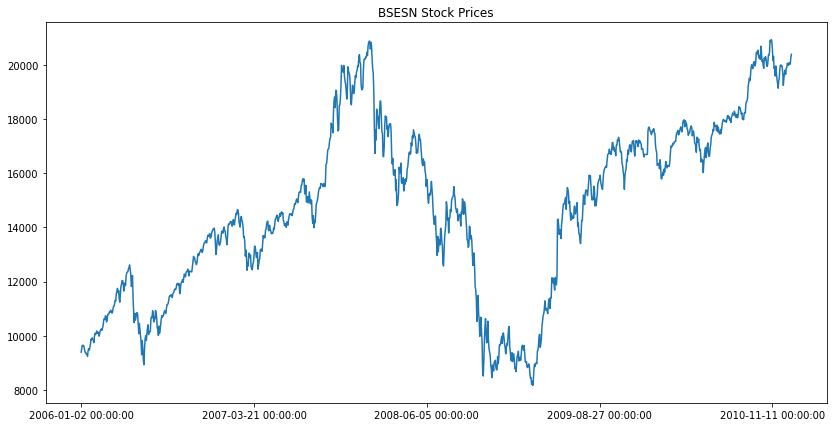

In [5]:
plt.figure(figsize=(14,7))
plt.title('BSESN Stock Prices')
plt.plot(df['Close'])
plt.xticks(np.arange(0,1500, 300), df['Date'][0:1500:300])
plt.show()

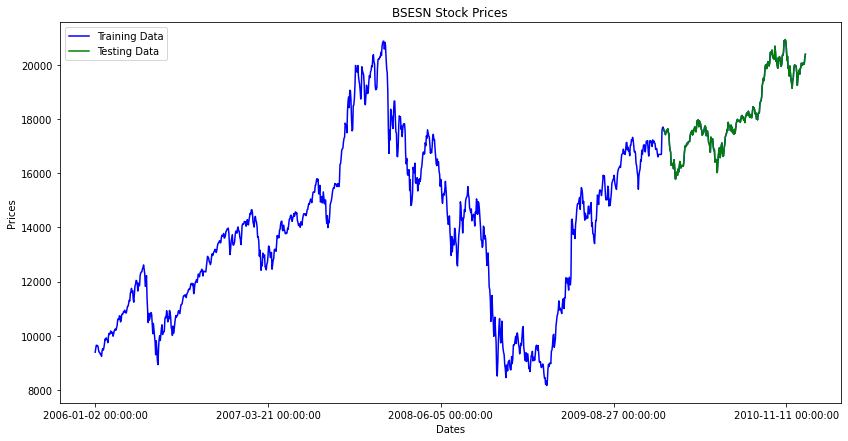

In [6]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(14,7))
plt.title('BSESN Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.xticks(np.arange(0,1500, 300), df['Date'][0:1500:300])
plt.legend()

### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

### ADF test

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [7]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.448789416529229
p-value: 0.558675490721378


p-value > 0.05, therefore the time series is not stationary.

In [8]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs
ndiffs(df.Close, test="adf")

1

Therefore d value is 1 

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. 

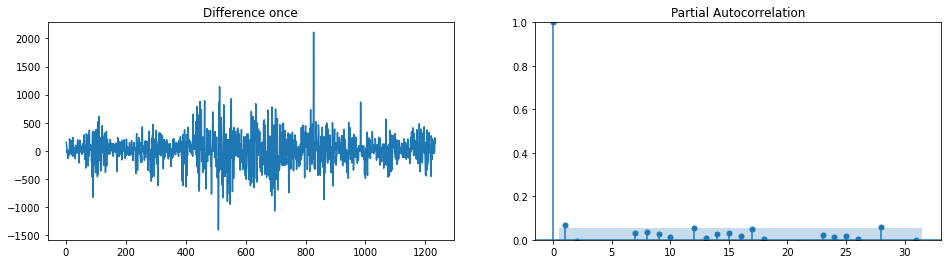

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

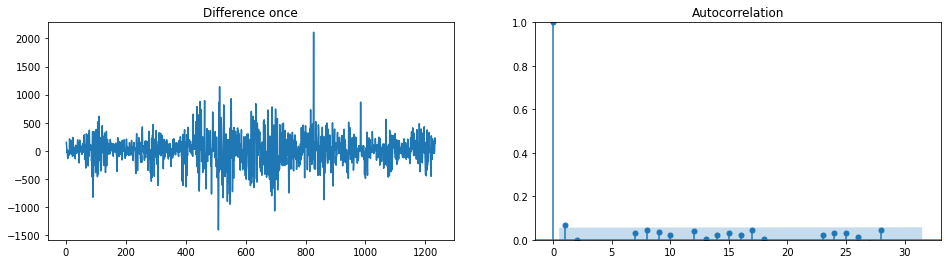

In [10]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

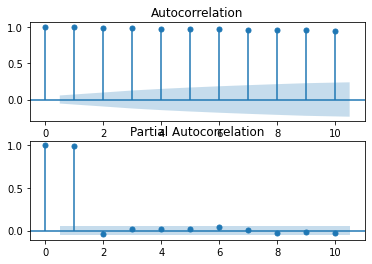

In [11]:
dataset=df.copy()
dataset.set_index('Date', inplace=True)
dataset = dataset[['Close']] 
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(dataset, ax=pyplot.gca(),lags=10)
pyplot.subplot(212)
plot_pacf(dataset, ax=pyplot.gca(),lags=10)
pyplot.show()

In order to evaluate the ARIMA model, I decided to use two different error functions: Mean Squared Error (MSE) and Symmetric Mean Absolute Percentage Error (SMAPE). SMAPE is commonly used as an accuracy measure based on relative errors.

SMAPE is not currently supported in Scikit-learn as a loss function I, therefore, had first to create this function on my own.

In [12]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

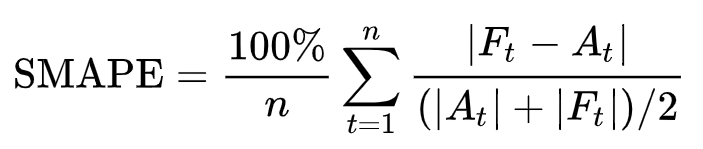

In [13]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 33910.630
Symmetric mean absolute percentage error: 8.380


SMAPE is commonly used loss function for Time Series problems and can, therefore, provide a more reliable analysis. That showed that our model is good.

In [14]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1232
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -8620.611
Method:                       css-mle   S.D. of innovations            264.623
Date:                Sun, 13 Dec 2020   AIC                          17251.221
Time:                        21:50:41   BIC                          17276.803
Sample:                             1   HQIC                         17260.845
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8100      7.326      1.203      0.229      -5.549      23.169
ar.L1.D.y      0.7589      0.161      4.723      0.000       0.444       1.074
ar.L2.D.y     -0.0794      0.029     -2.765      0.0

<AxesSubplot:>

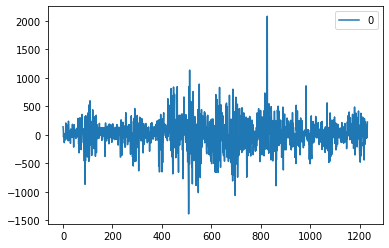

In [15]:
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

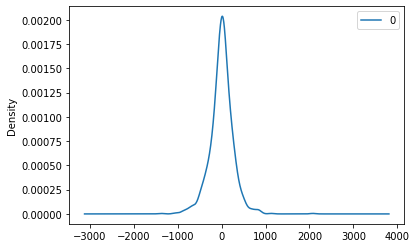

In [16]:
residuals.plot(kind='kde')

In [17]:
residuals.describe()

,0
count,1232.000000
mean,0.004552
std,264.730673
min,-1389.414936
25%,-129.448966
50%,10.510853
75%,138.316537
max,2077.986686


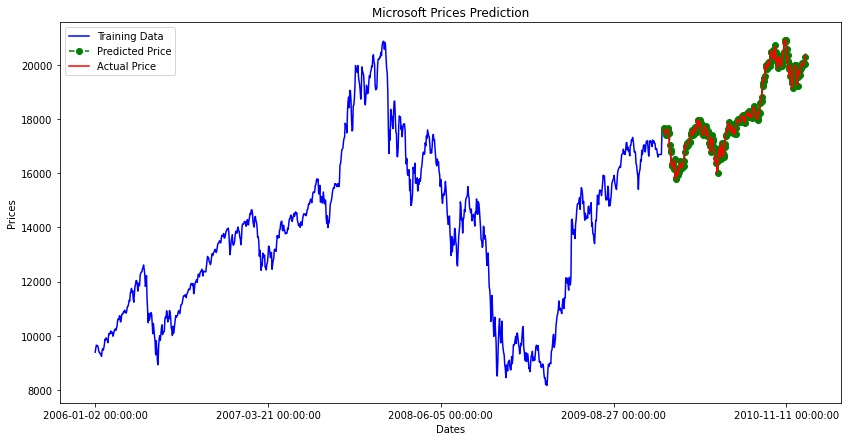

In [18]:
plt.figure(figsize=(14,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,1500, 300), df['Date'][0:1500:300])
plt.legend()

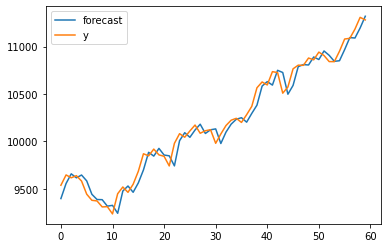

In [19]:
# Actual vs Fitted
model_fit.plot_predict(
    start=1,
    end=60,
    dynamic=False,
);

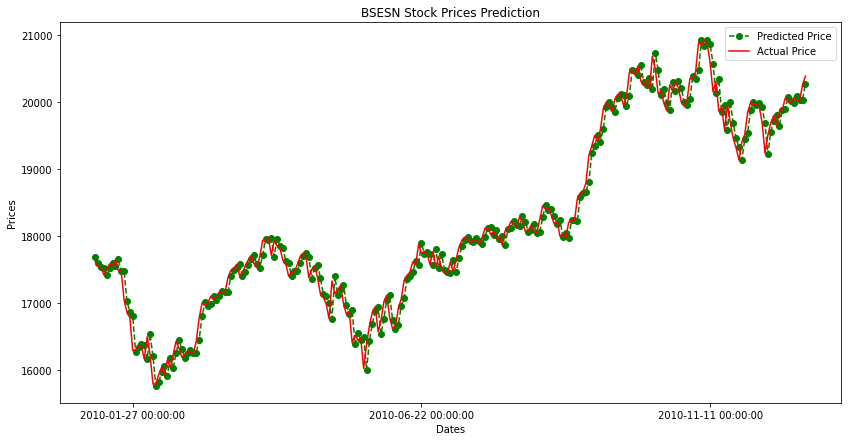

In [20]:
plt.figure(figsize=(14,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.legend()
plt.title('BSESN Stock Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(1000,1259,100), df['Date'][1000:1259:100])
plt.legend()

The above image is a zoomed in version. From this can be noticed how the two curves closely follow each other. However, the predicted price seems to look like a “noisy” version of the actual price.

This analysis using ARIMA lead overall to appreciable results. This model demonstrated in fact to offer good prediction accuracy and to be relatively fast compared to other alternatives such as RRNs (Recurrent Neural Networks).

# Sentiment analysis

## NLTK's VADER module
VADER is an NLTK module that provides sentiment scores based on words used ("completely" boosts a score, while "slightly" reduces it), on capitalization & punctuation ("GREAT!!!" is stronger than "great."), and negations (words like "isn't" and "doesn't" affect the outcome).
<br>To view the source code visit https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [21]:
import pandas as pd #Importing the PANDAS python library
import numpy as np #importing Numpy
%matplotlib inline 
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #initiating VADER instance
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [22]:
headlines= pd.read_csv("C:\\Users\\Kv\\Desktop\\The Sparks Foundation\\stock price prediction\\india-news-headlines.csv")
headlines.head()
# cleaning dataset
#Drop rows with missing values
headlines.dropna(inplace=True)

In [23]:
headlines.tail()

,Date,headline_text
643711,20101231,Leopard cub found dead near Ballarpur
643712,20101231,Massive rally by students for T state
643713,20101231,Men on bike cut elderly woman's earlobes; make...
643714,20101231,3 security guards arrested for chain-snatchings
643715,20101231,Modala Sala


In [24]:
headlines["Date"] = pd.to_datetime(headlines["Date"],format='%Y%m%d')
headlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643716 entries, 0 to 643715
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           643716 non-null  datetime64[ns]
 1   headline_text  643716 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 14.7+ MB


In [25]:
headlines.shape

(643716, 2)

In [26]:
#Grouping the headlines for each day
#headlines['headline_text'] = headlines.groupby(['Date']).transform(lambda x : ' '.join(x)) 
headlines = headlines.drop_duplicates(subset='Date', keep='first', inplace=False) 
headlines.reset_index(inplace = True, drop = True)
headlines

,Date,headline_text
0,2006-01-01,Hit list cited to shoot down CM's website
1,2006-01-02,20 dancing girls
2,2006-01-03,Furore over road model patent
3,2006-01-04,Dual citizenship for Pravasi Indians
4,2006-01-05,Sania sizzles in doubles
...,...,...
1821,2010-12-27,PM's heart surgeon injured in road mishap
1822,2010-12-28,Sangeetha 's fun-filled B'day bash
1823,2010-12-29,Diwali Gala Charity Banquet
1824,2010-12-30,Watch: Top news in one minute


In [27]:
headlines.shape

(1826, 2)

In [28]:
#Calculating score for each news headline in the dataframe/dataset
i=0 #counter
compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores
while i<len(headlines):
    
    k = analyser.polarity_scores(headlines.iloc[i]['headline_text'])
    compval1.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage
compval1 = np.array(compval1)
len(compval1)

1826

In [29]:
headlines['VADER score'] = compval1

In [30]:
headlines.head(20)

,Date,headline_text,VADER score
0,2006-01-01,Hit list cited to shoot down CM's website,-0.3400
1,2006-01-02,20 dancing girls,0.0000
2,2006-01-03,Furore over road model patent,0.0000
3,2006-01-04,Dual citizenship for Pravasi Indians,0.0000
4,2006-01-05,Sania sizzles in doubles,0.0000
5,2006-01-06,20 action babes,0.0000
6,2006-01-07,Caught after 4 uncertain days,-0.2960
7,2006-01-08,20 swimsuit sirens,0.0000
8,2006-01-09,The Mahatma's tale,0.0000
9,2006-01-10,Amar Singh moves SC; Advani; Mamata join tap d...,0.2960


In [31]:
i = 0
predicted_value = [ ] #empty series to hold our predicted values
while(i<len(headlines)):
    if ((headlines.iloc[i]['VADER score'] >= 0.1)):
        predicted_value.append('positive')
        i = i+1
    elif ((headlines.iloc[i]['VADER score'] > -0.1) & (headlines.iloc[i]['VADER score'] < 0.1)):
        predicted_value.append('neutral')
        i = i+1
    elif ((headlines.iloc[i]['VADER score'] <= -0.1)):
        predicted_value.append('negative')
        i = i+1

In [32]:
headlines['sentiment'] = predicted_value
headlines.head(10)

,Date,headline_text,VADER score,sentiment
0,2006-01-01,Hit list cited to shoot down CM's website,-0.340,negative
1,2006-01-02,20 dancing girls,0.000,neutral
2,2006-01-03,Furore over road model patent,0.000,neutral
3,2006-01-04,Dual citizenship for Pravasi Indians,0.000,neutral
4,2006-01-05,Sania sizzles in doubles,0.000,neutral
5,2006-01-06,20 action babes,0.000,neutral
6,2006-01-07,Caught after 4 uncertain days,-0.296,negative
7,2006-01-08,20 swimsuit sirens,0.000,neutral
8,2006-01-09,The Mahatma's tale,0.000,neutral
9,2006-01-10,Amar Singh moves SC; Advani; Mamata join tap d...,0.296,positive


In [33]:
headlines.sentiment.value_counts()

neutral     1046
positive     496
negative     284
Name: sentiment, dtype: int64

### Hybrid

In [34]:
df_merge = pd.merge(df, headlines, how='left', on='Date')
df_merge

,Date,Close,headline_text,VADER score,sentiment
0,2006-01-02,9390.139648,20 dancing girls,0.0000,neutral
1,2006-01-03,9539.370117,Furore over road model patent,0.0000,neutral
2,2006-01-04,9648.080078,Dual citizenship for Pravasi Indians,0.0000,neutral
3,2006-01-05,9617.740234,Sania sizzles in doubles,0.0000,neutral
4,2006-01-06,9640.290039,20 action babes,0.0000,neutral
...,...,...,...,...,...
1229,2010-12-24,20073.660160,The Tourist,0.0000,neutral
1230,2010-12-27,20028.929690,PM's heart surgeon injured in road mishap,-0.4019,negative
1231,2010-12-28,20025.419920,Sangeetha 's fun-filled B'day bash,0.0000,neutral
1232,2010-12-29,20256.029300,Diwali Gala Charity Banquet,0.4215,positive


In [35]:
new_df=df_merge[['Close','sentiment']]
new_df

,Close,sentiment
0,9390.139648,neutral
1,9539.370117,neutral
2,9648.080078,neutral
3,9617.740234,neutral
4,9640.290039,neutral
...,...,...
1229,20073.660160,neutral
1230,20028.929690,negative
1231,20025.419920,neutral
1232,20256.029300,positive


In [36]:
new_df.groupby(['sentiment']).mean()

,Close
sentiment,
negative,14631.007866
neutral,14775.091689
positive,14533.227952
